# Load and visualize the EUROCONTROL R&D Data Archive sample 

#### EUROCONTROL R&D archive data & information can be found here: https://www.eurocontrol.int/dashboard/rnd-data-archive

In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
from io import BytesIO
import requests
from zipfile import ZipFile
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from archive import Sample, get_trajs, get_airspaces, get_all_airports

#### <br> Archive sample can be directly loaded from EUROCONTROL website with the following URL

In [3]:
sample_zip_url = "https://www.eurocontrol.int/archive_download/all/node/12418"

In [4]:
def get_zip(file_url):
    url = requests.get(file_url)
    zipfile = ZipFile(BytesIO(url.content))
    zip_names = zipfile.namelist()
    if len(zip_names) == 1:
        file_name = zip_names.pop()
        extracted_file = zipfile.open(file_name)
        return extracted_file
    return [zipfile.open(file_name) for file_name in zip_names]

#### <br> Load sample as pandas dataframes

In [5]:
sample_zip = get_zip(sample_zip_url)  # or use directly zip file that you saved locally
sample = Sample(sample_zip)

#### <br> Flights

In [6]:
sample.flights_df.head()

,ECTRL ID,ADEP,ADEP Latitude,ADEP Longitude,ADES,ADES Latitude,ADES Longitude,FILED OFF BLOCK TIME,FILED ARRIVAL TIME,ACTUAL OFF BLOCK TIME,ACTUAL ARRIVAL TIME,AC Type,AC Operator,AC Registration,ICAO Flight Type,STATFOR Market Segment,Requested FL,Actual Distance Flown (nm)
0,184409764,LFPG,49.00972,2.54778,LEMG,36.67500,-4.49917,2015-01-03 05:55:00,2015-01-03 08:18:23,2015-01-03 05:51:00,2015-01-03 08:11:21,A319,EZY,GEZDW,S,Lowcost,370,856
1,184410592,LFPG,49.00972,2.54778,LEBL,41.29694,2.07833,2015-01-03 06:40:00,2015-01-03 08:09:32,2015-01-03 06:41:00,2015-01-03 08:12:17,A321,AFR,FGTAS,S,Traditional Scheduled,330,502


In [7]:
airports = get_all_airports(sample.flights_df)
airports.head()

,airport,geometry
0,LFPG,POINT (2.54778 49.00972)
1,LFPG,POINT (2.54778 49.00972)
2,LEMG,POINT (-4.49917 36.67500)
3,LEBL,POINT (2.07833 41.29694)


#### <br> Flight points

In [8]:
sample.flight_points_actual_df.head()

,ECTRL ID,Sequence Number,Time Over,Flight Level,Latitude,Longitude
0,184409764,0,2015-01-03 05:51:00,0,49.00972,2.54778
1,184409764,1,2015-01-03 06:07:00,0,49.00972,2.54778
2,184409764,2,2015-01-03 06:10:16,90,48.98417,2.34639
3,184409764,3,2015-01-03 06:12:44,125,48.96445,1.99806
4,184409764,4,2015-01-03 06:15:51,212,48.65389,1.99417


In [9]:
trajs = get_trajs(sample.flight_points_actual_df)
trajs.head()

,geometry
ECTRL ID,
184409764,"LINESTRING (2.54778 49.00972, 2.54778 49.00972..."
184410592,"LINESTRING (2.54778 49.00972, 2.54778 49.00972..."


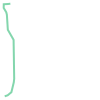

In [10]:
trajs.loc[184410592].values[0]

#### <br> Flight airspaces

In [11]:
sample.firs_df.head()

,Airspace ID,Min Flight Level,Max Flight Level,Sequence Number,Latitude,Longitude
0,LECBFIR,0,245,1,42.84528,0.75000
1,LECBFIR,0,245,2,42.85000,0.73333
2,LECBFIR,0,245,3,42.69306,0.55833
3,LECBFIR,0,245,4,42.70000,0.41667
4,LECBFIR,0,245,5,42.70000,0.36667


In [12]:
airspaces = get_airspaces(sample.firs_df)
airspaces.head(7)

,geometry
LECBFIR,"POLYGON ((0.75000 42.84528, 0.73333 42.85000, ..."
LECBUIR,"POLYGON ((0.75000 42.84528, 0.73333 42.85000, ..."
LECMFIR,"POLYGON ((-12.91667 45.00000, -13.00000 45.000..."
LECMUIR,"POLYGON ((-12.91667 45.00000, -13.00000 45.000..."
LFFFFIR,"POLYGON ((2.24500 51.10139, 2.00000 51.11667, ..."
LFFFUIR,"POLYGON ((2.00000 51.11667, 1.73222 51.05861, ..."


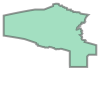

In [13]:
airspaces.loc["LFFFUIR"].values[0]  # France UIR

#### <br> Plot with background map

In [14]:
figsize = (20, 20)  # (18, 18)
first_cmap = "Spectral"
flights_cmap = "cool"
airport_icon_path = "http://maps.google.com/mapfiles/kml/shapes/airports.png"
airport_icon = plt.imread(airport_icon_path)
airport_icon_zoom = 0.4
airport_name_vertical_shift = 60000
airport_name_fontsize = 12
airspace_alpha = 0.3
ctx_zoom = 6
file_name = "sample.png"

In [15]:
airspaces_3857 = airspaces.to_crs(epsg=3857)  # web mercator
trajs_3857 = trajs.to_crs(epsg=3857)
airspaces_3857.reset_index(inplace=True)
trajs_3857.reset_index(inplace=True)
airports_3857 = airports.to_crs(epsg=3857)

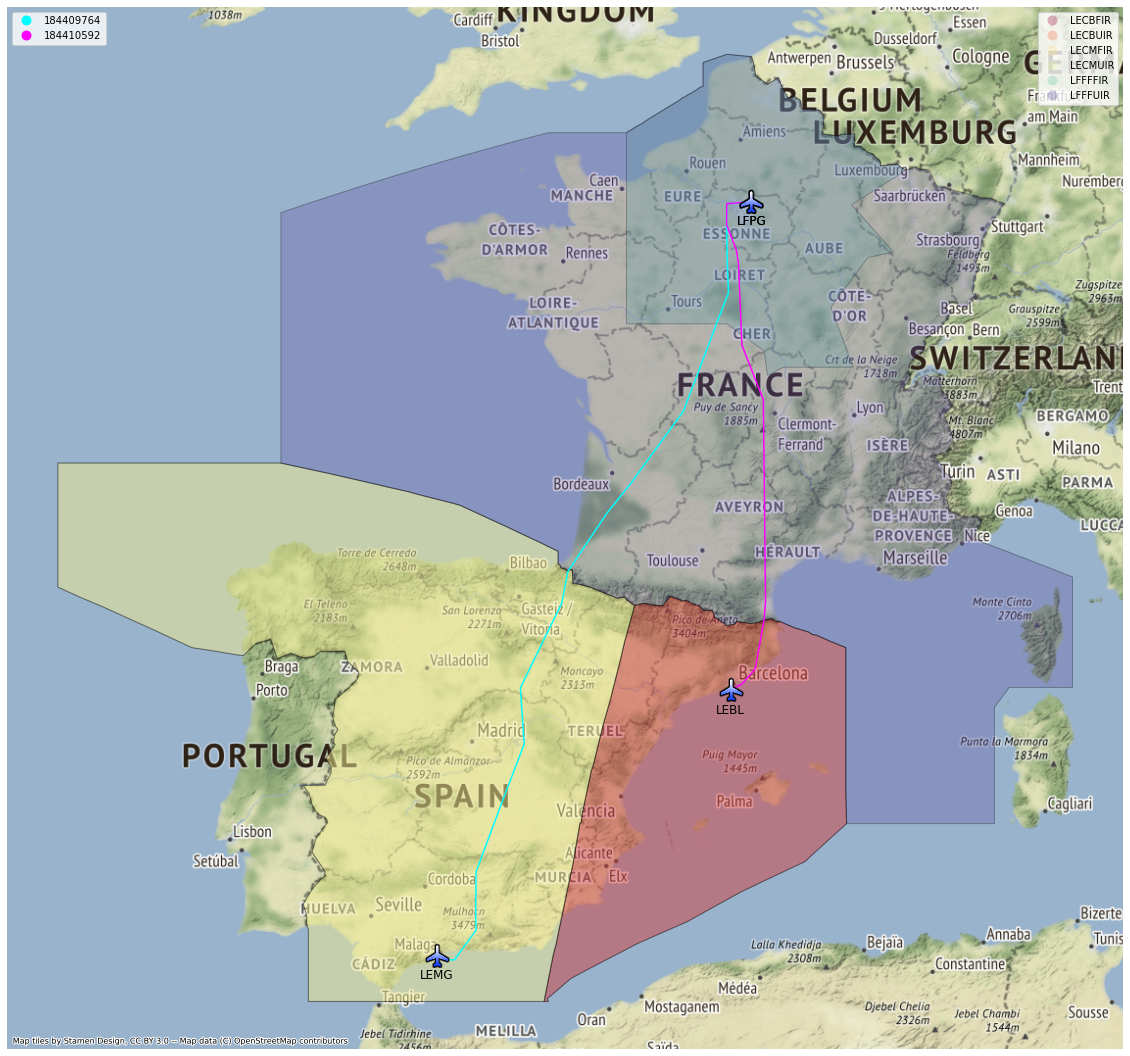

In [16]:
f, ax = plt.subplots(figsize=figsize)
airspaces_3857.plot(
    ax=ax,
    edgecolor="black",
    alpha=airspace_alpha,
    cmap=first_cmap,
    legend=True,
    column="index",
)
leg1 = ax.get_legend()
trajs_3857.plot(
    ax=ax,
    column="ECTRL ID",
    categorical=True,
    legend=True,
    cmap=flights_cmap,
    legend_kwds={"loc": "upper left"},
)
airports_3857.plot(ax=ax)

for i, r in airports_3857.iterrows():
    posx, posy = (r[1].x, r[1].y)
    ab = AnnotationBbox(
        OffsetImage(airport_icon, zoom=airport_icon_zoom), (posx, posy), frameon=False,
    )
    ax.add_artist(ab)
    plt.text(
        posx,
        posy - airport_name_vertical_shift,
        r[0],
        horizontalalignment="center",
        fontsize=airport_name_fontsize,
    )

ctx.add_basemap(ax, zoom=ctx_zoom)
ax.set_axis_off()
ax.add_artist(leg1)
plt.savefig(file_name, bbox_inches="tight", pad_inches=-0.1)